In [33]:
#codigo de :https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

: 

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers






2023-06-11 10:17:51.391297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 10:17:52.281271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-11 10:17:52.281298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-11 10:17:52.375085: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-11 10:17:54.985243: W tensorflow/stream_executor/platform/de

In [2]:
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
display(df.head(2))
print(f"df.shape = {df.shape}")

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1577836800000,7195.24,7245.00,7175.46,7224.21,3646.232354,1577858399999,2.631450e+07,44901,1987.278850,1.434351e+07,0
1,1577858400000,7224.24,7237.73,7180.00,7197.20,4415.466238,1577879999999,3.182890e+07,51073,2173.642319,1.566963e+07,0


df.shape = (4984, 12)


In [3]:
# Change the time unit of the "open_time" and "close_time" columns
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])
df = df.set_index('open_time')

Text(0, 0.5, 'Prices ($)')

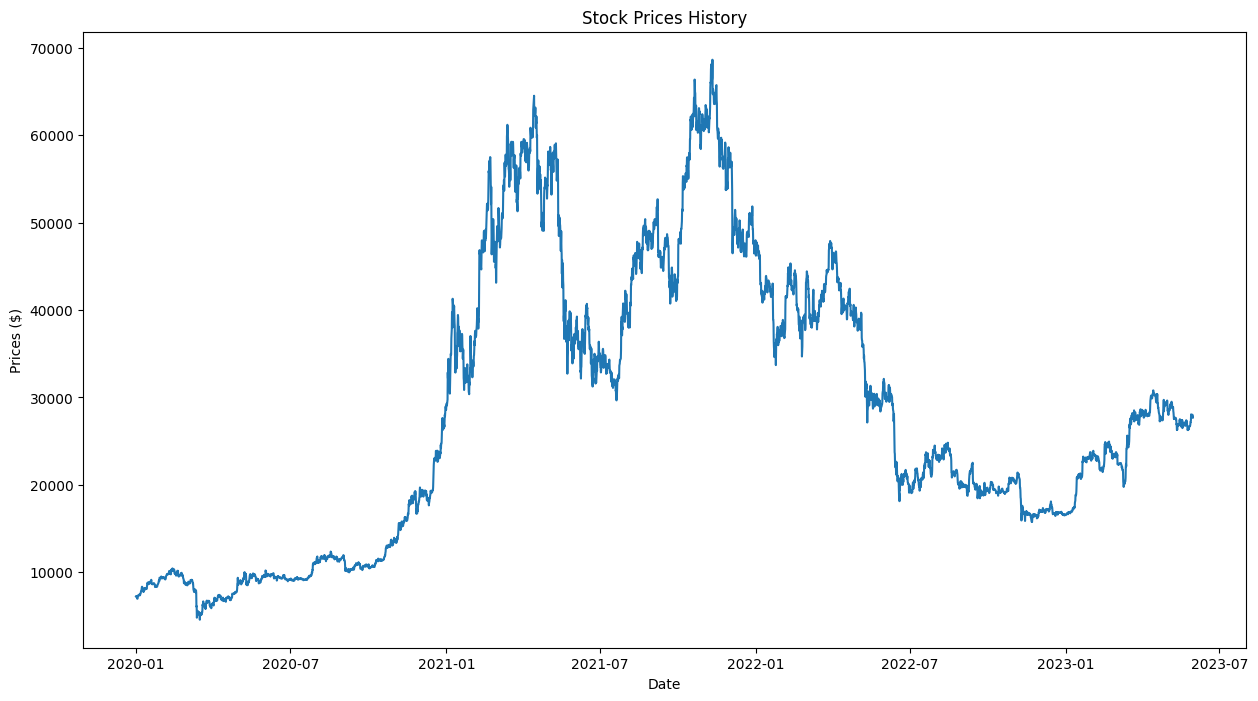

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
close_prices = df['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60*4, len(train_data)):
    x_train.append(train_data[i-(60*4):i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60*4, len(test_data)):
  x_test.append(test_data[i-(60*4):i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

2023-06-11 10:17:58.264760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-11 10:17:58.264841: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-11 10:17:58.264973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Yass): /proc/driver/nvidia/version does not exist
2023-06-11 10:17:58.266710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow import keras
from keras.callbacks import EarlyStopping


def fit_model(model, verbose=1):

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(x_train,
                        y_train,
                        validation_split=0.3,
                        shuffle=False,
                        batch_size=32,
                        epochs=4,
                        callbacks=[es],
                        verbose=verbose)

    return model, history

In [14]:

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3


KeyboardInterrupt: 

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

26/26 [==============================] - 5s 148ms/step


274.6729919349961

KeyError: "['close'] not in index"

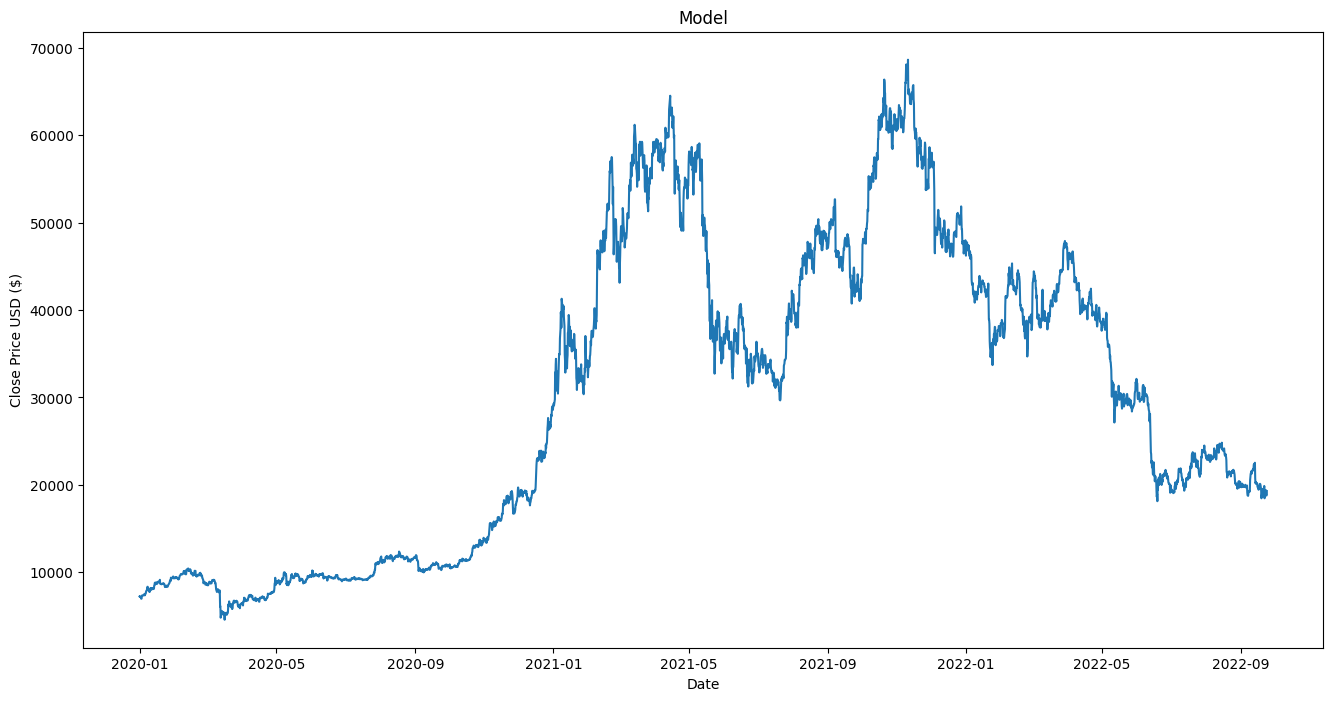

In [32]:
data = df['close']
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()





In [18]:
data = {'y_test': y_test, 'predictions': predictions}
datos = pd.DataFrame(data, index=range(len(y_test)))

# Mostrar el DataFrame
print(df)

ValueError: Data must be 1-dimensional